In [ ]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

In [ ]:
df = pd.read_csv("marketing_campaign.csv", sep='\t')

# Compute total spend
df['MntTotal'] =  df[['MntWines', 'MntFruits', 'MntMeatProducts',
                     'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

df['Age'] = 2021 - df['Year_Birth'] ##data deposited 4 years ago

# Normalize predictors
df['Income_z'] = (df['Income'] - df['Income'].mean()) / df['Income'].std()

df['Age_z'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()

Each customer $i$ spends an amount $y_i$ in the last two years. $\beta_1$ and $\beta_2$ represent the importance of income and age repectively in the amount spent by each customers.

The prior on $\beta_1$ and $\beta_2$:
$$
 \beta_1 \sim \mathcal{N}(0, 5)
$$

$$
 \beta_2 \sim \mathcal{N}(0, 5)
$$

and $y_i$ is sampled from the following normal distribution:
$$
 y_i \sim \mathcal{N}(\mu_i, \sigma^2)
$$
 such the $\mu_i$ is written as linear combination of income and age:



$$
\mu_i = \beta_1 * income + \beta_2 * age 
$$



In [ ]:
y = df['MntTotal'].values
x_income = df['Income_z'].values
x_age = df['Age_z'].values

N = len(y)

In [25]:
# --- NumPyro Model ---
def hierarchical_model(income, age, y=None):
    
   
     # Global coefficients
    beta1 = numpyro.sample('beta1', dist.Normal(0., 5.))  # income
    beta2 = numpyro.sample('beta2', dist.Normal(0., 5.))  # age

    # Observation noise
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # Expected value
    mu =  beta1 * income + beta2 * age

    # Likelihood
    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)




In [27]:
# --- Inference ---
rng_key = random.PRNGKey(0)
kernel = NUTS(hierarchical_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=5)
mcmc.run(rng_key, income=x_income, age=x_age,  y=y)
mcmc.print_summary()

/var/folders/k3/2_5qkn113ms8_fqvzb5ykrzc0000gp/T/ipykernel_966/3967161713.py:4: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=5)
sample: 100%|██████████| 4000/4000 [00:00<00:00, 6689.14it/s, 3 steps of size 8.09e-01. acc. prob=0.90]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1     63.56      4.72     63.56     55.73     71.21  13042.28      1.00
     beta2      9.22      4.60      9.22      1.39     16.56  14500.47      1.00
     sigma    542.21      4.33    542.21    535.30    549.55  15124.33      1.00

Number of divergences: 0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

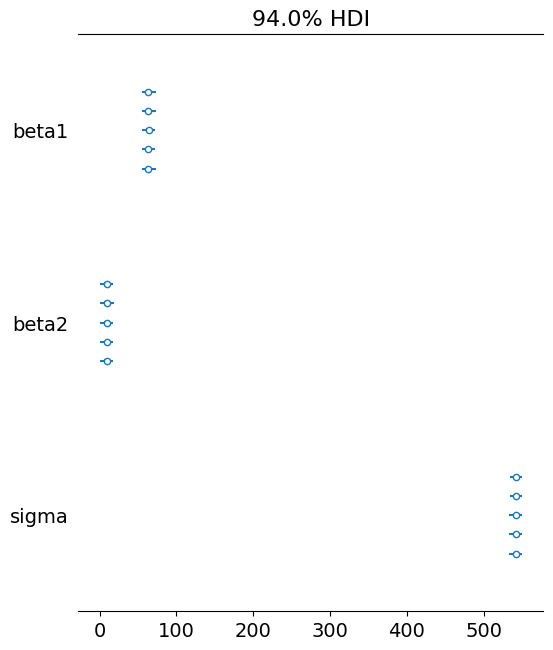

In [28]:
idata = az.from_numpyro(mcmc)
az.plot_forest(idata, var_names=[ "beta1", "beta2", "sigma"])

array([[<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

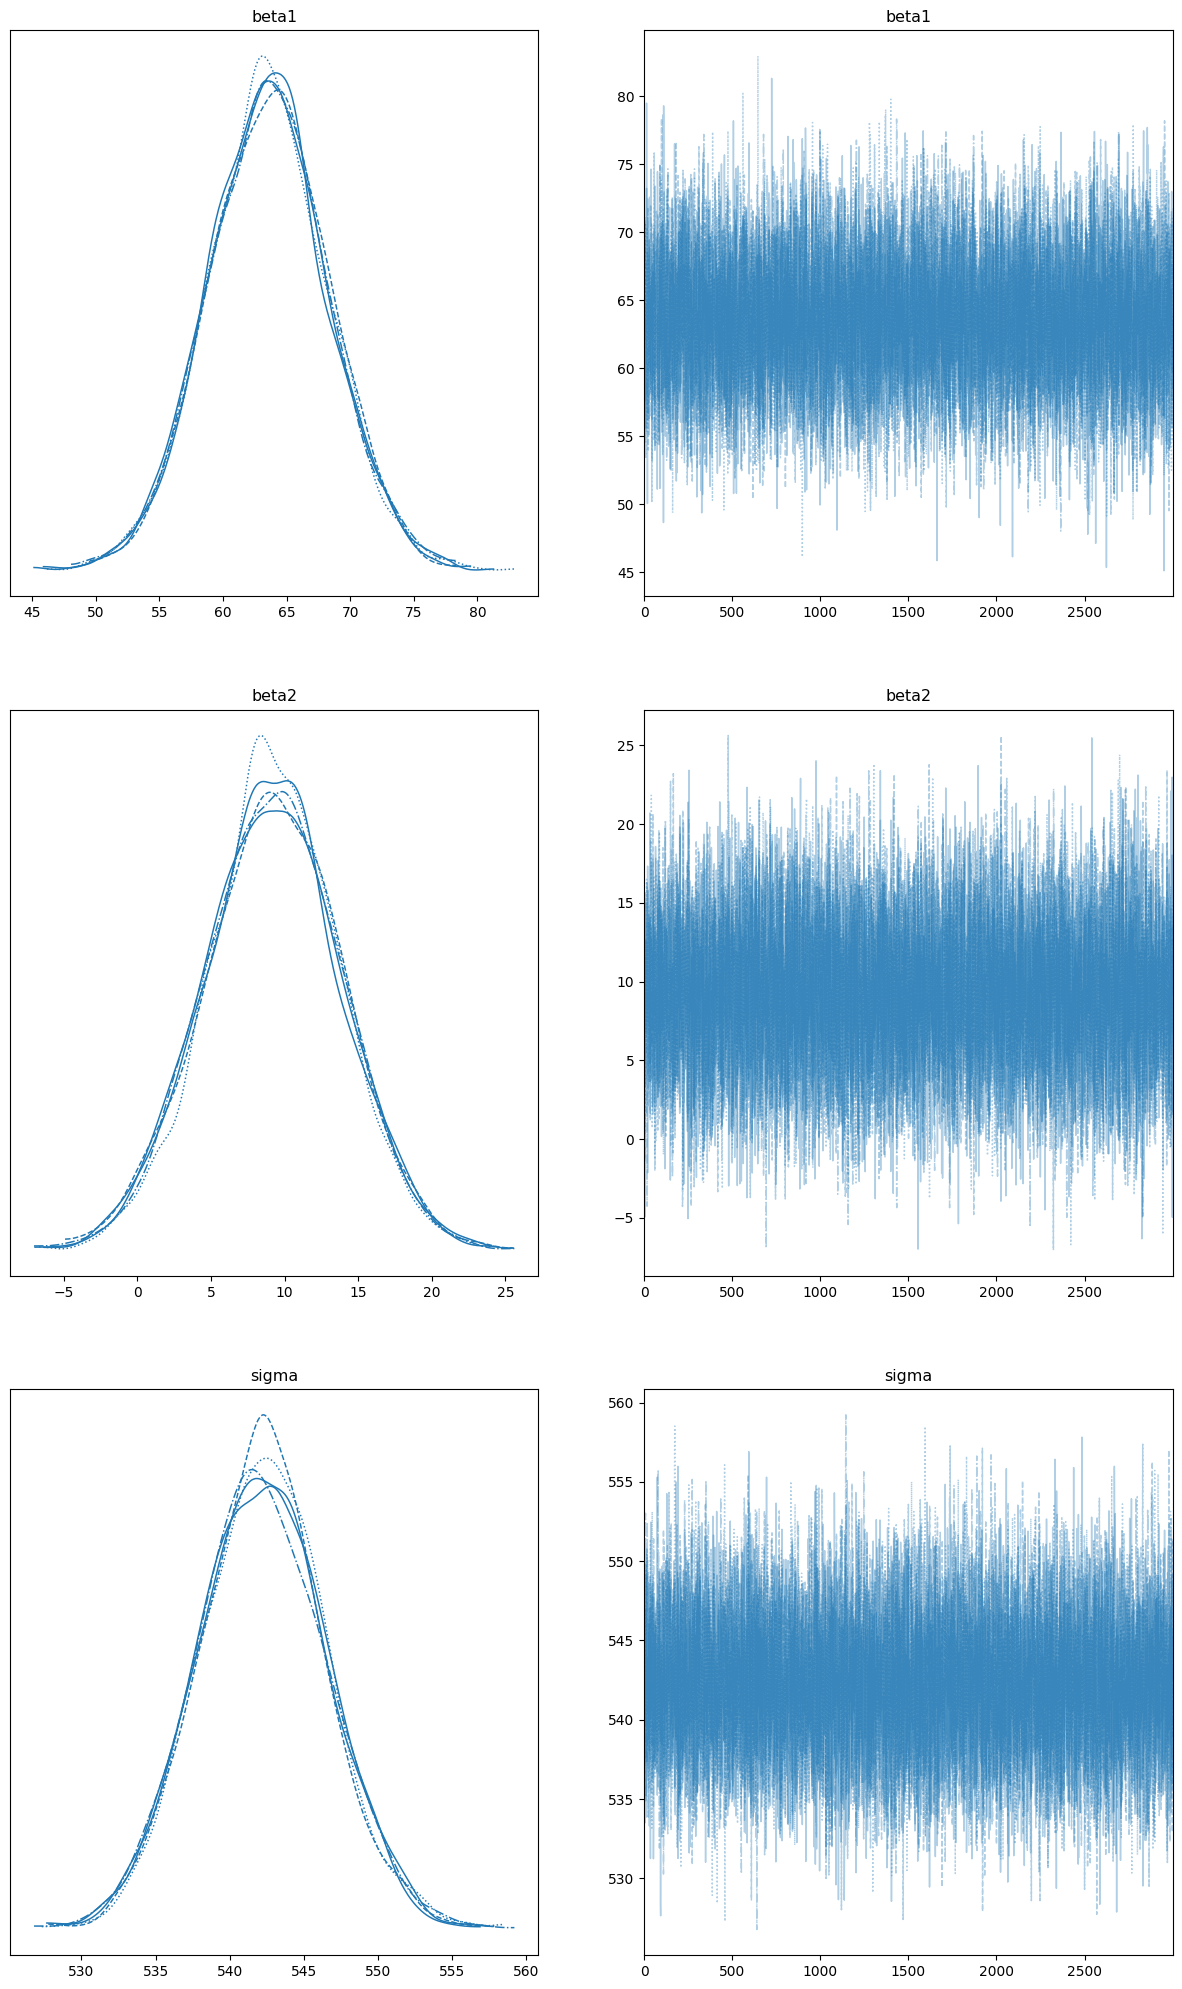

In [29]:
az.plot_trace(idata, compact=True, figsize=(15, 25))

Now lets add the effect of education $\beta_0$ of each customer to the total amount spent $y_i$. 

The new linear equation of $\mu_i$:
$$
\mu_i = \beta_{0,j}  + \beta_1 * income + \beta_2 * age 
$$

$$
j \in \{\text{Graduation}, \text{PhD}, \text{Master}, \text{Basic}, \text{2nd Cycle}\}
$$w

$$
 \beta_{0,j} \sim \mathcal{N}(\mu_{\beta_{0}}, \tau)
$$

$$
 \mu_{\beta_{0}} \sim \mathcal{N}(0, 10)
$$

$$
 \tau \sim \mathcal{N}(0, 10)
$$

In [ ]:
df = df.dropna(subset=['Income', 'Education', 'Age'])
df['Education_cat'], education_levels = pd.factorize(df['Education'])
education_idx = df['Education_cat'].values
J = len(np.unique(education_idx))  # number of groups

In [ ]:
def hierarchical_model(income, age, edu_idx, y=None):
   
    mu_beta0 = numpyro.sample('mu_beta0', dist.Normal(0., 10.))
    tau = numpyro.sample('tau', dist.HalfNormal(5.))
    
    # Group-level intercepts (one per education group)
    with numpyro.plate("education_groups", J):
        beta0 = numpyro.sample('beta0', dist.Normal(mu_beta0, tau))

   
    beta1 = numpyro.sample('beta1', dist.Normal(0., 5.))  
    beta2 = numpyro.sample('beta2', dist.Normal(0., 5.))  

    
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

  
    mu = beta0[edu_idx] + beta1 * income + beta2 * age

   
    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)




In [39]:
# --- Inference ---
rng_key = random.PRNGKey(0)
kernel = NUTS(hierarchical_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=5)
mcmc.run(rng_key, income=x_income, age=x_age, edu_idx = education_idx,  y=y)
mcmc.print_summary()

/var/folders/k3/2_5qkn113ms8_fqvzb5ykrzc0000gp/T/ipykernel_966/3561263505.py:4: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=5)
sample: 100%|██████████| 4000/4000 [00:01<00:00, 3303.38it/s, 7 steps of size 6.68e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta0[0]    604.51     12.15    604.44    585.51    625.28  27772.47      1.00
  beta0[1]    621.04     18.34    620.89    590.81    651.11  27427.65      1.00
  beta0[2]    560.07     20.68    559.94    526.27    594.39  26741.55      1.00
  beta0[3]    148.24     44.52    148.14     75.17    221.04  27389.04      1.00
  beta0[4]    450.01     27.07    450.27    405.17    494.09  27935.51      1.00
     beta1     95.89      4.57     95.90     88.55    103.53  26490.31      1.00
     beta2     10.35      4.36     10.34      3.21     17.46  26811.67      1.00
  mu_beta0     41.93     10.07     41.86     25.90     59.16  27529.49      1.00
     sigma    407.69      4.10    407.69    400.88    414.35  26665.60      1.00
       tau     72.16      2.68     72.13     67.88     76.66  23891.00      1.00

Number of divergences: 0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

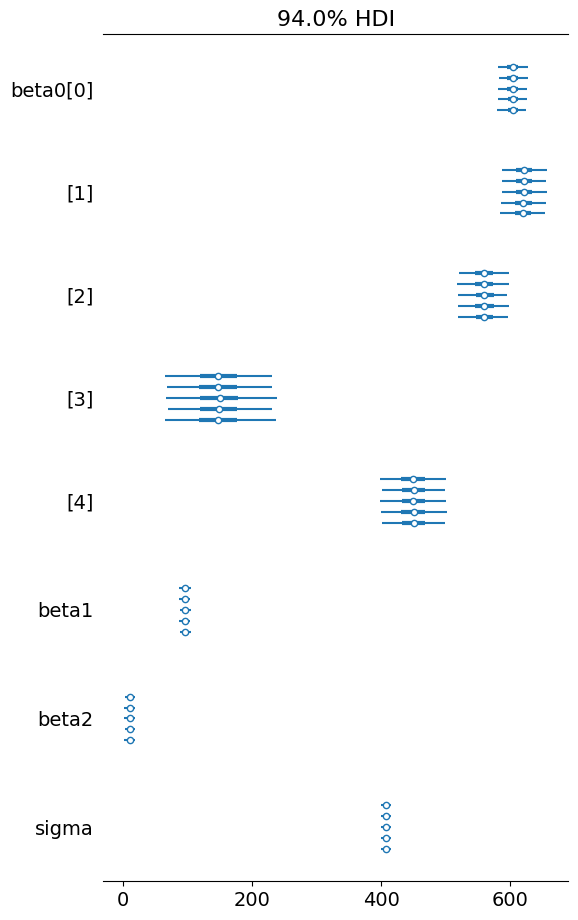

In [40]:
idata = az.from_numpyro(mcmc)
az.plot_forest(idata, var_names=["beta0", "beta1", "beta2", "sigma"])

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'mu_beta0'}>,
        <Axes: title={'center': 'mu_beta0'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

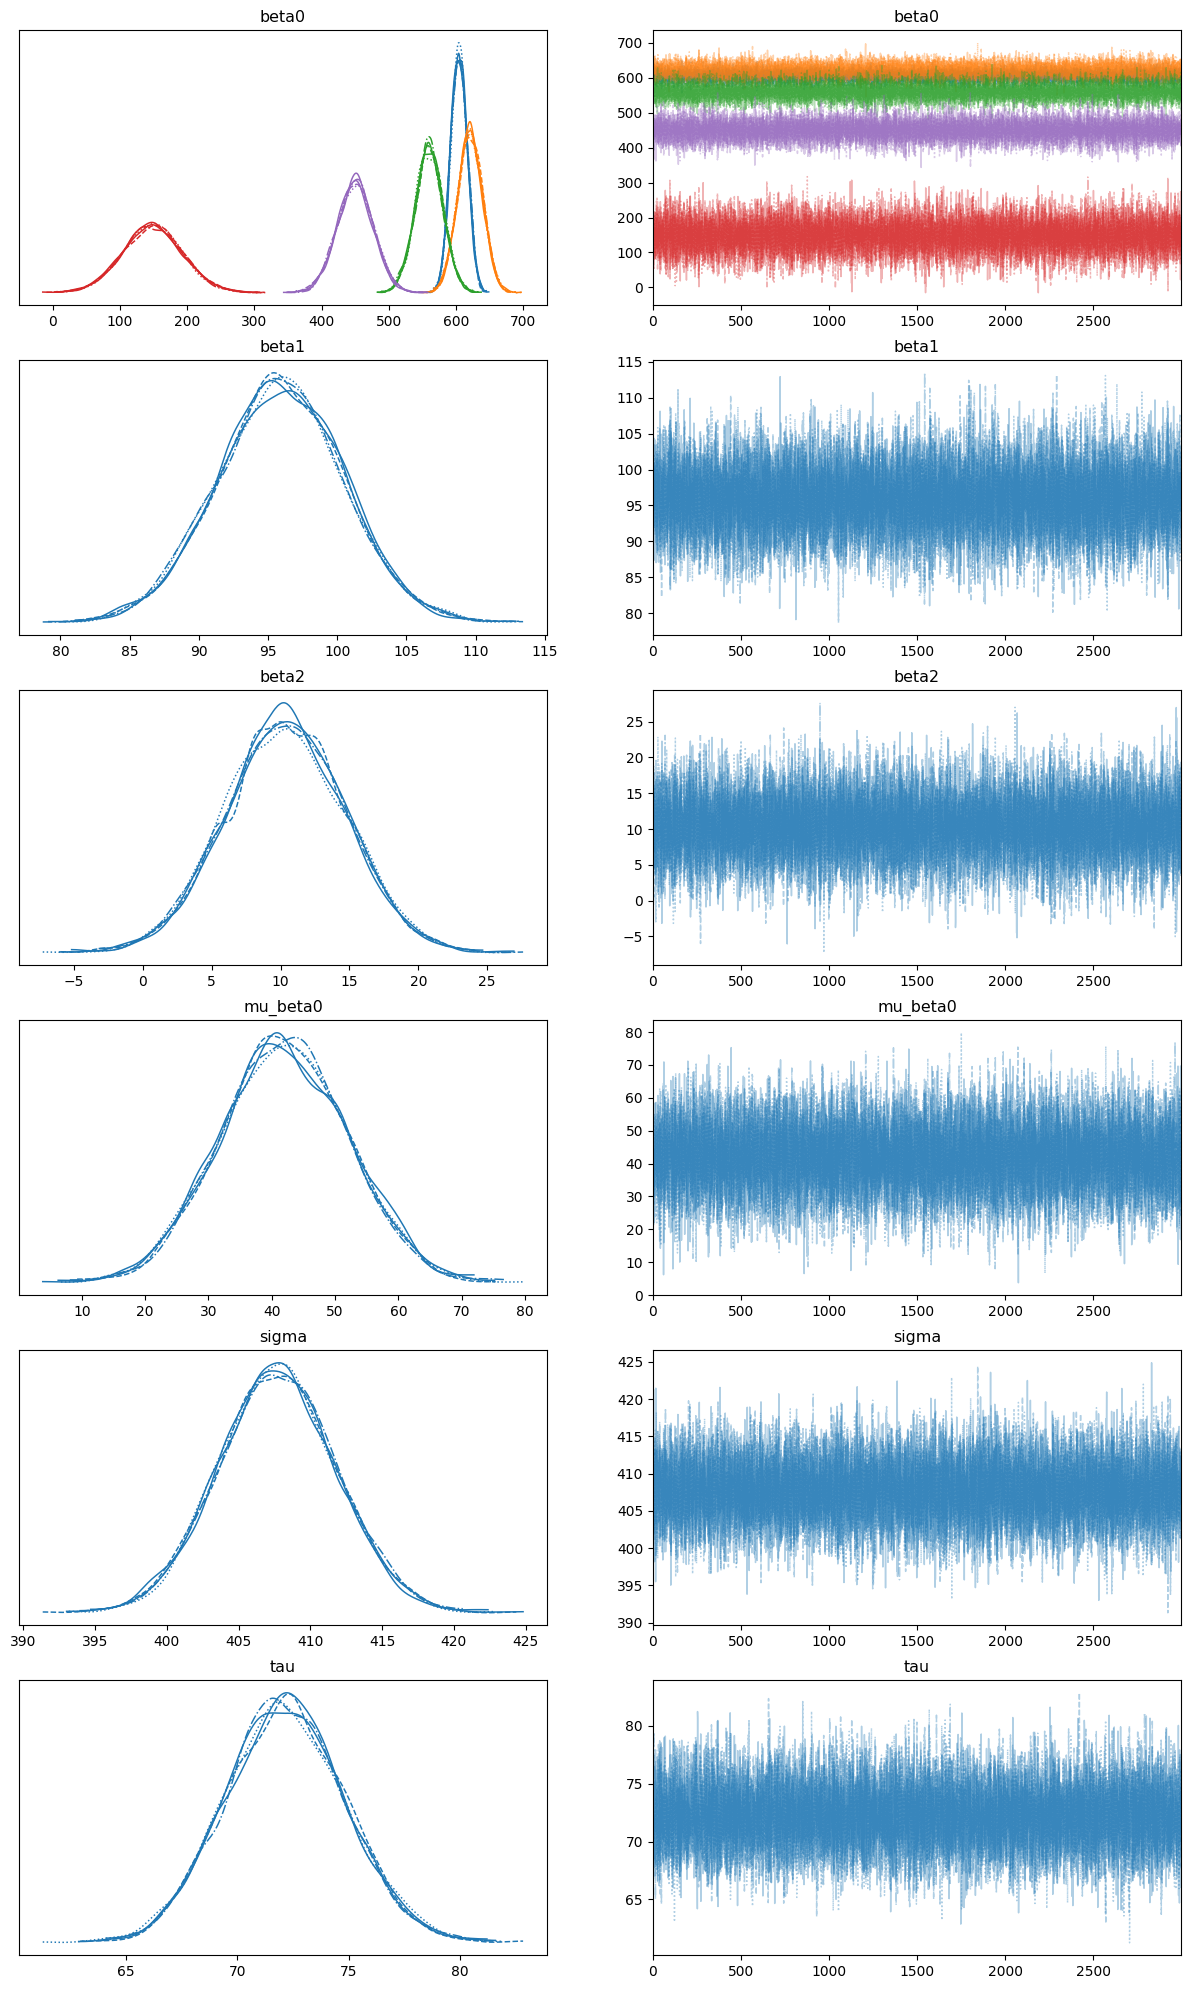

In [41]:
az.plot_trace(idata, compact=True, figsize=(15, 25))

Finally lets try adding the effect of the martial status $\alpha$ on the spent amount $y_i$. 



The new linear equation of $\mu_i$:
$$
\mu_i = \alpha_{m} + \beta_{0,j}  + \beta_1 * income + \beta_2 * age 
$$

$$
m \in \{\text{Single}, \text{Together}, \text{Married}, \text{Divorced}, \text{Widow}, \text{Widow}, \text{Alone}, \text{Absurd},\text{YOLO}\}
$$

In [42]:
df = df.dropna(subset=['Income', 'Education', 'Age', 'Marital_Status'])
df['Martial_Status_cat'], martial_status = pd.factorize(df['Marital_Status'])
martial_status_idx = df['Martial_Status_cat'].values
M = len(np.unique(martial_status_idx))

In [ ]:

def hierarchical_model(income, age, edu_idx, mart_idx, y=None):
    
    mu_beta0 = numpyro.sample('mu_beta0', dist.Normal(0., 10.))
    mu_alpha = numpyro.sample('mu_alpha', dist.Normal(0., 10.))
    tau = numpyro.sample('tau', dist.HalfNormal(5.))
    
    
    with numpyro.plate("education_groups", J):
        beta0 = numpyro.sample('beta0', dist.Normal(mu_beta0, tau))
    
    with numpyro.plate("martial_status_groups", M):
        alpha = numpyro.sample('alpha', dist.Normal(mu_alpha, tau))

    
    beta1 = numpyro.sample('beta1', dist.Normal(0., 5.))  
    beta2 = numpyro.sample('beta2', dist.Normal(0., 5.))  


    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

  
    mu = beta0[edu_idx] + alpha[mart_idx] + beta1 * income + beta2 * age


  
    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y)




In [44]:
# --- Inference ---
rng_key = random.PRNGKey(0)
kernel = NUTS(hierarchical_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=5)
mcmc.run(rng_key, income=x_income, age=x_age, edu_idx=education_idx,mart_idx = martial_status_idx, y=y)
mcmc.print_summary()

/var/folders/k3/2_5qkn113ms8_fqvzb5ykrzc0000gp/T/ipykernel_966/3564922269.py:4: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=5)
sample: 100%|██████████| 4000/4000 [00:02<00:00, 1899.43it/s, 7 steps of size 3.83e-01. acc. prob=0.90] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]    267.11     27.08    267.02    221.36    310.49   4505.11      1.00
  alpha[1]    254.51     26.04    254.40    211.26    295.72   4125.98      1.00
  alpha[2]    248.71     24.94    248.58    208.78    290.36   3777.86      1.00
  alpha[3]    227.66     30.57    227.66    177.61    277.89   5918.43      1.00
  alpha[4]    237.92     40.65    238.14    172.06    305.52   9861.33      1.00
  alpha[5]     24.45     60.24     24.51    -73.53    124.52  14949.60      1.00
  alpha[6]     62.25     60.64     62.01    -37.79    161.14  14851.14      1.00
  alpha[7]     30.97     60.73     30.99    -71.39    128.93  15806.27      1.00
  beta0[0]    356.40     24.26    356.46    316.06    395.84   3491.22      1.00
  beta0[1]    377.55     26.91    377.44    332.66    421.15   4660.47      1.00
  beta0[2]    319.65     28.44    319.81    272.18    365.54   5157.10      1.00
  beta0[3]    -10.31     43

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

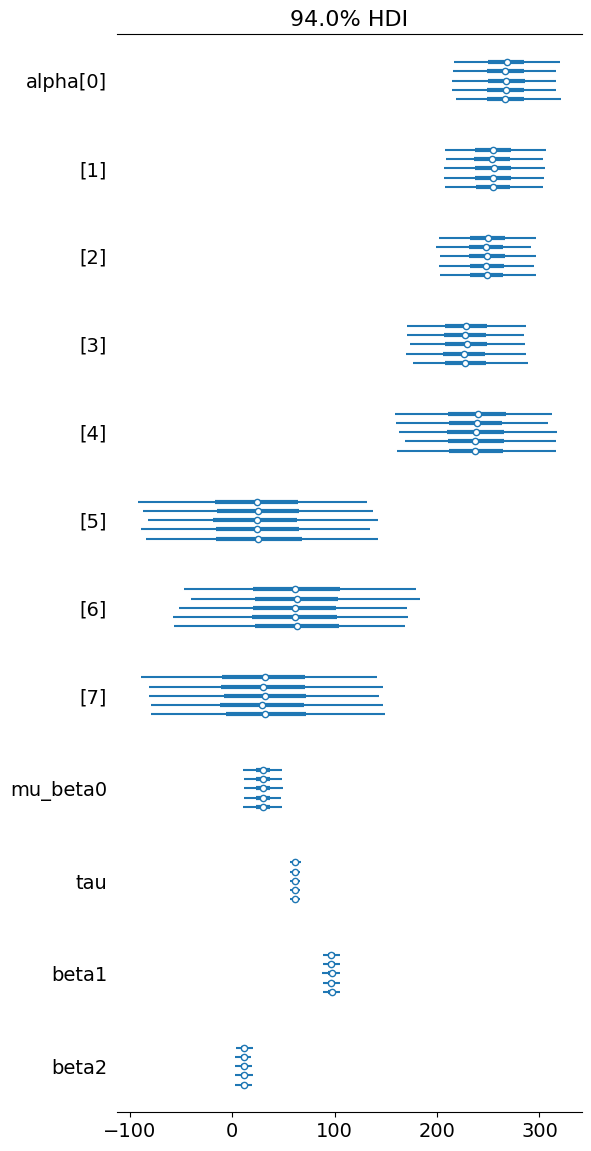

In [45]:
idata = az.from_numpyro(mcmc)
az.plot_forest(idata, var_names=["alpha", "mu_beta0", "tau", "beta1", "beta2"])

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'mu_alpha'}>,
        <Axes: title={'center': 'mu_alpha'}>],
       [<Axes: title={'center': 'mu_beta0'}>,
        <Axes: title={'center': 'mu_beta0'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

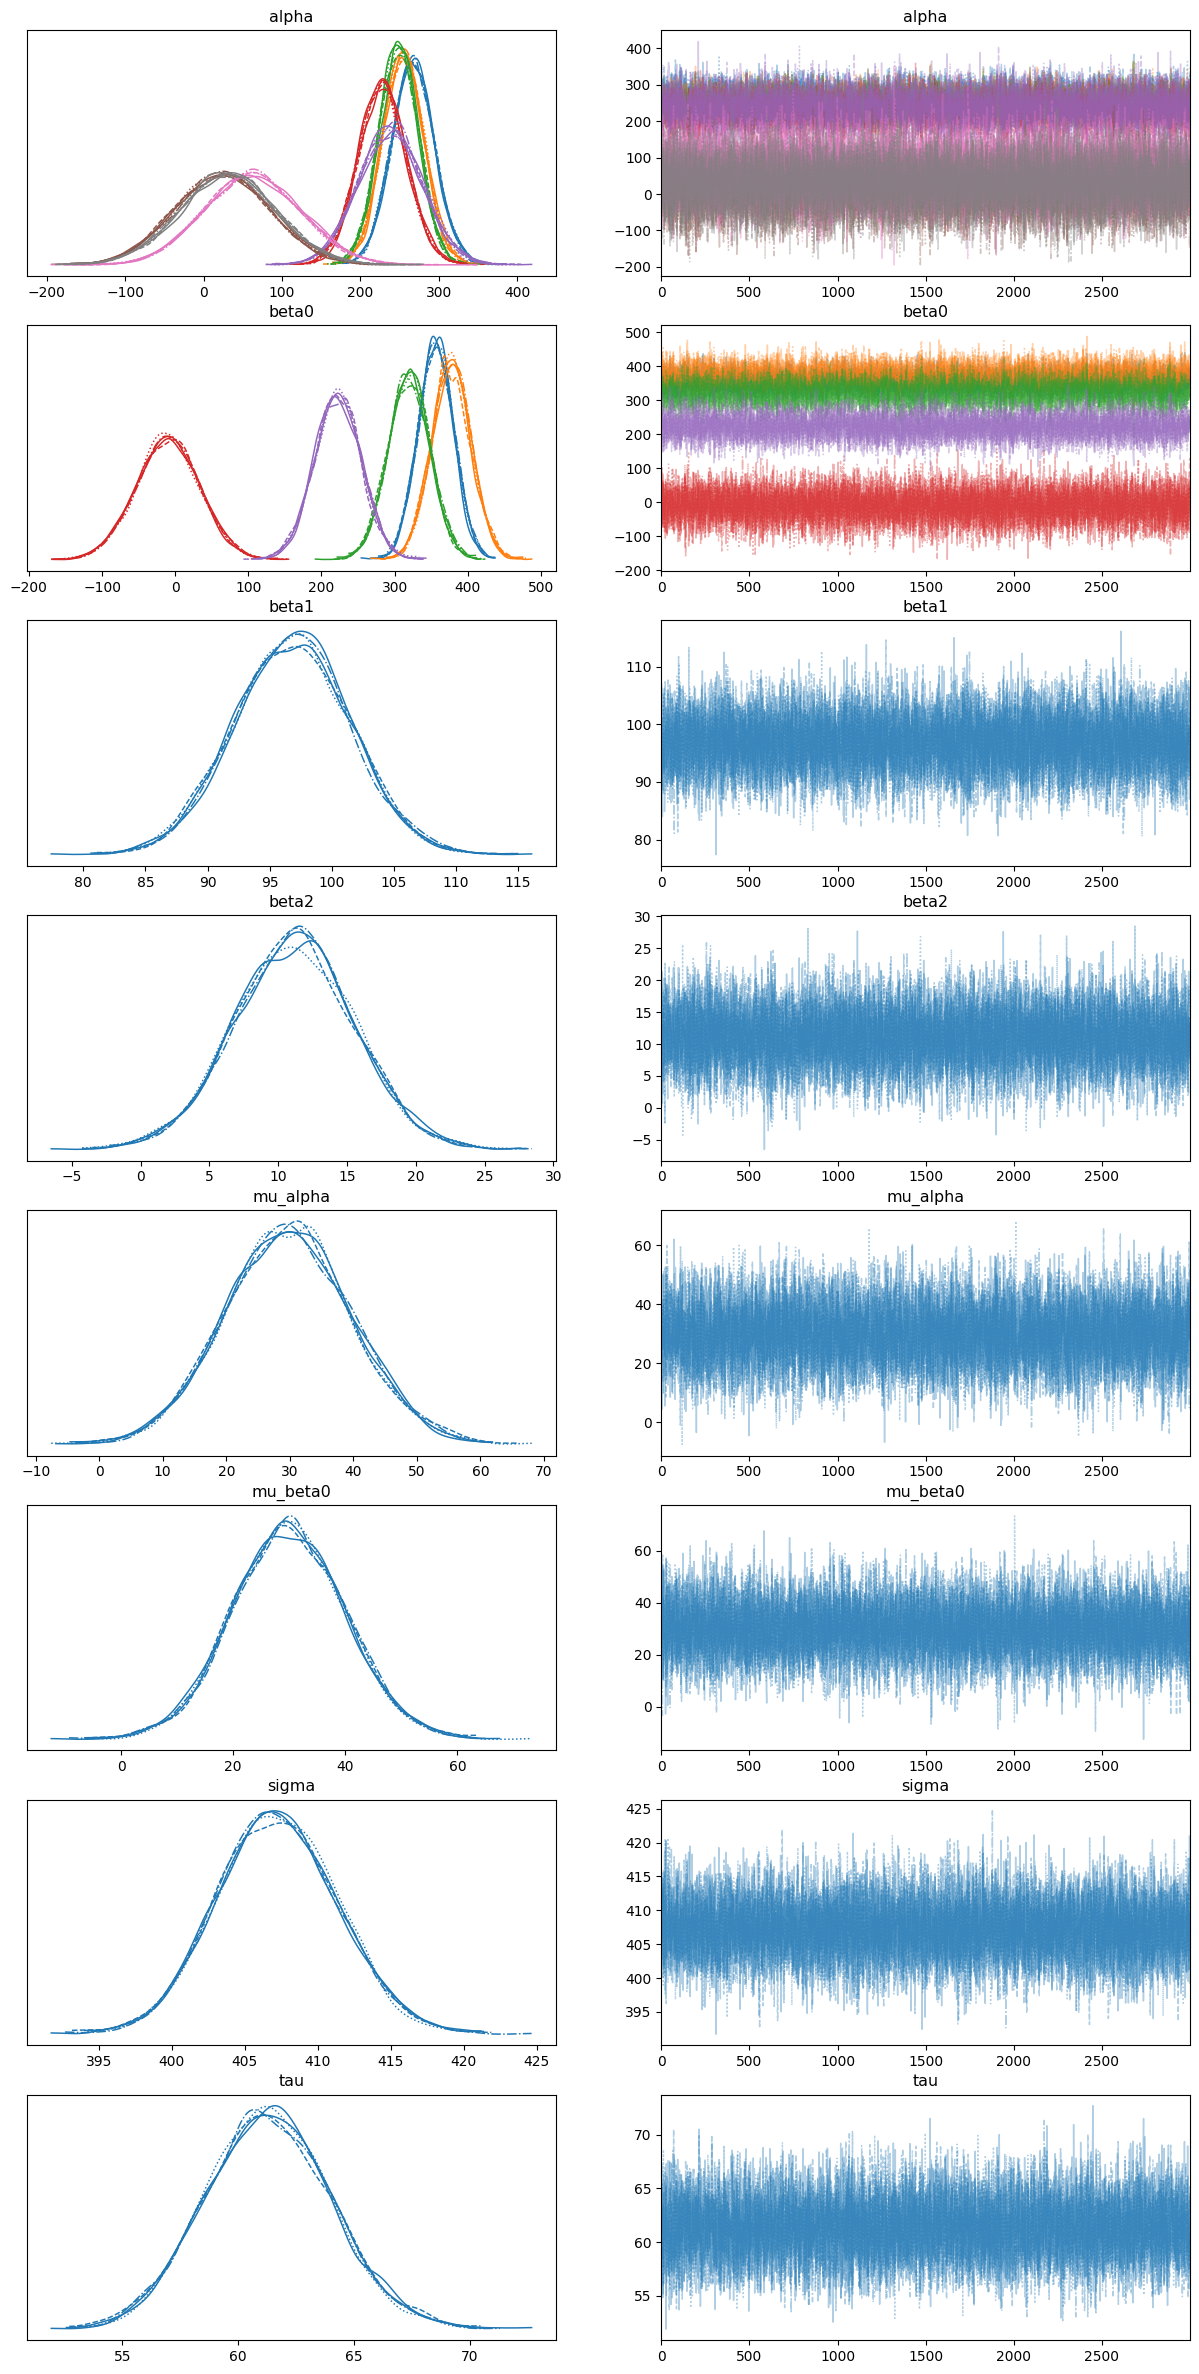

In [46]:
az.plot_trace(idata, compact=True, figsize=(15, 30))

In [ ]:
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
y_matrix = df[product_cols].values  # shape [N, K]

In [ ]:
def hierarchical_model(income, age, edu_idx, y_matrix):
    N, K = y_matrix.shape  # N customers, K products

    # Hyperpriors for intercepts
    mu_beta0 = numpyro.sample("mu_beta0", dist.Normal(0., 10.))
    tau = numpyro.sample("tau", dist.HalfNormal(5.))

    # Group-level intercepts (education-specific)
    with numpyro.plate("education", J):
        beta0 = numpyro.sample("beta0", dist.Normal(mu_beta0, tau))  # shape [J]

    # Global coefficients
    beta1 = numpyro.sample("beta1", dist.Normal(0., 5.))  # income
    beta2 = numpyro.sample("beta2", dist.Normal(0., 5.))  # age

    # Observation noise per product
    with numpyro.plate("products", K):
        sigma = numpyro.sample("sigma", dist.HalfNormal(10.))

    # Compute shared mean per customer (shape [N])
    mu_shared = beta0[edu_idx] + beta1 * income + beta2 * age  # shape [N]
    
    # Broadcast mu to shape [N, K]
    mu = jnp.repeat(mu_shared[:, None], K, axis=1)  # shape [N, K]

    # Observation model
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=y_matrix)
